## Step 1: Basic Exploratory Data Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Basic per device metrics and Data Quality

In [2]:
df = pd.read_csv("../data/device_failure.csv")
df.loc[:,'date'] = pd.to_datetime(df['date'])

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [4]:
df.isnull().describe()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
count,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494,124494
mean,0,0,0,0,0,0,0,0,0,0,0,0
std,0,0,0,0,0,0,0,0,0,0,0,0
min,False,False,False,False,False,False,False,False,False,False,False,False
25%,0,0,0,0,0,0,0,0,0,0,0,0
50%,0,0,0,0,0,0,0,0,0,0,0,0
75%,0,0,0,0,0,0,0,0,0,0,0,0
max,False,False,False,False,False,False,False,False,False,False,False,False


In [5]:
df["date"].describe()

count                  124494
unique                    304
top       2015-01-03 00:00:00
freq                     1163
first     2015-01-01 00:00:00
last      2015-11-02 00:00:00
Name: date, dtype: object

### Good. At least no null values

In [6]:
total_obs = df.shape[0]
unique_dev = df.device.unique().shape[0]
print ("Total Observations        : %s"%total_obs)
print ("Unique Devices            : %s"%unique_dev)
print ("Unique devices that failed: %d"%df[df['failure'] == 1].device.unique().size)
print ("Avg number of observations per device: %f"%(float(total_obs)/unique_dev))

Total Observations        : 124494
Unique Devices            : 1168
Unique devices that failed: 106
Avg number of observations per device: 106.587329


### Distribution of number of readings for devices
#### NumDevices/day that were observed --> points to systemic ingestion/sampling problem

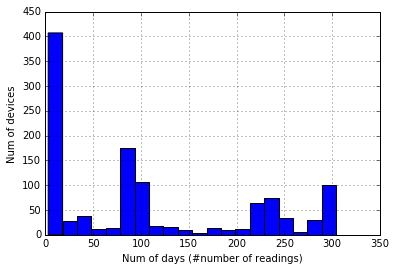

In [7]:
df.groupby(["device"]).count()["attribute1"].hist(bins=20)
plt.xlabel("Num of days (#number of readings)")
plt.ylabel("Num of devices")

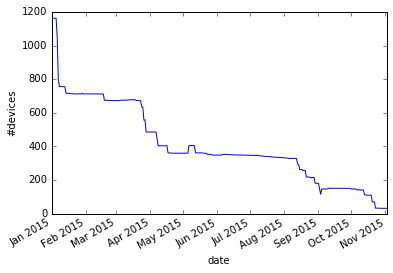

In [8]:
df.groupby(["date"]).count()["device"].plot.line()
plt.ylabel("#devices")

#### See if there are gaps in dates for sensor data. See how bad it is

In [9]:
df_date_min = df.groupby("device").min()["date"]
df_date_max = df.groupby("device").max()["date"]
df_date_count = df.groupby("device").count()["date"]
df2 = pd.concat([df_date_min, df_date_max, df_date_count], axis=1)
df2.columns = ["start", "end", "xcount"]
df2.loc[:,"diff_dates"] = (df2.end - df2.start).dt.days+1
df2.loc[:,'deltas'] = df2.diff_dates - df2.xcount
df2.loc[:,'missing'] = df2.deltas.map(lambda x: x != 0)
df2.groupby("missing").count()["start"]

missing
False    997
True     171
Name: start, dtype: int64

#### At least majority of cases, readings are continuous
##### For missing data, how many days are we missing?

In [10]:
missing = df2[df2["missing"] == True]
missing.loc[:,"miss_pct"] = (missing["deltas"]/missing["diff_dates"])*100
missing.miss_pct.describe()

/home/vagrant/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/vagrant/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


count    171.000000
mean      27.568382
std       30.822808
min        0.653595
25%        0.701754
50%       15.116279
75%       43.494856
max       93.129771
Name: miss_pct, dtype: float64

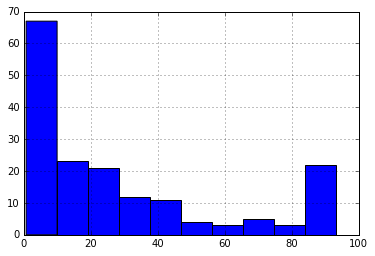

In [11]:
missing.miss_pct.hist()

## Summary
#### We have data issues, but I think we have enough data to get started
#### Work with internal and external operations in parallel